# Airbus Ship Detection

## Memebers
* Blaine Rothrock (BRY4768)
* Ilan Ponsky (IPW1530)
* Will Dong (WDG4518)

## Overview

Based on the kaggle challenge [Airbus Ship Detection Challenge](https://www.kaggle.com/c/airbus-ship-detection/overview). This challenge uses satellite images to detect if a image has ships and draw a box (mask) around the ship. This challenge contains ~40GB of data and the training size is a little out of scope for this project, so we approaching it with two goals:
1. Trainin a binary classifier to classify images that contain ship(s)
2. Explore the state-of-the-art approach to this model, U-Net
    - Goal is to follow the baseline notebook submission and understand the architechure. 

## 1. Binary Classifier

In [29]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise, BatchNormalization, concatenate, Cropping2D, ZeroPadding2D, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from skimage.io import imread
from sklearn.model_selection import train_test_split

from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gc

gc.enable()

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

print(tf.__version__)

2.1.0


In [2]:
# define params for the model
class Params():
    def __init__(self):
        self.batch_size = 128
        self.epochs = 25
        self.image_size = (256, 256)
        
params = Params()

In [3]:
# read the mask data provided by kaggle
seg = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(seg.shape[0], 'masks found')
print(seg['ImageId'].value_counts().shape[0], 'unique images found')
seg.sample()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
156984,ad4cbaf50.jpg,127973 3 128737 7 129502 10 130270 10 131039 1...


In [4]:
# identify images that have a mask (ship identification)
def agg_ship_count(seg):
    seg['ship_count'] = seg['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
    seg.sample(10)

    # aggregate ship images and sum number of ships
    unique_seg = seg.groupby('ImageId').agg({'ship_count': 'sum'}).reset_index()
    unique_seg['file_size_kb'] = unique_seg['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024 if os.path.exists(os.path.join(train_image_dir, c_img_id)) else 0.0)
    unique_seg = unique_seg[unique_seg['file_size_kb']>50] 
    unique_seg.drop(['file_size_kb'], axis=1, inplace=True)

    unique_seg['has_ship'] = unique_seg['ship_count'].map(lambda x: 1 if x > 0.0 else 0)
    unique_seg['class'] = unique_seg['ship_count'].map(lambda x: 'ship' if x > 0.0 else 'no_ship')

    return unique_seg

train_df = agg_ship_count(pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')))
train_df.sample(10)

,ImageId,ship_count,has_ship,class
50139,42c6165b5.jpg,0,0,no_ship
146846,c33b6f61a.jpg,0,0,no_ship
114186,97ce4b3df.jpg,0,0,no_ship
168621,e0486b154.jpg,0,0,no_ship
187771,f9bce9370.jpg,0,0,no_ship
131053,ae36ae069.jpg,0,0,no_ship
99598,847c32266.jpg,3,1,ship
113387,96c7e17cf.jpg,0,0,no_ship
7119,097d83ec2.jpg,0,0,no_ship
102586,886df2530.jpg,0,0,no_ship


In [5]:
# Create a validation set by splitting the training data
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.3,
    stratify = train_df['has_ship']
)

print(train_df.shape[0], 'training samples')
print(valid_df.shape[0], 'validation samples')

133902 training samples
57387 validation samples


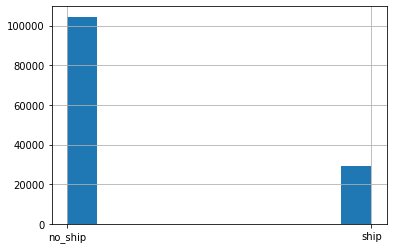

In [6]:
train_df['class'].hist()

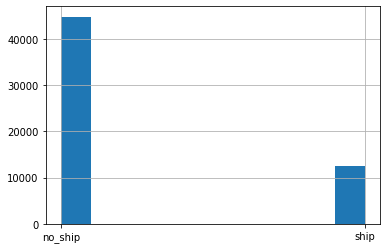

In [7]:
valid_df['class'].hist()

In [8]:
# normalize the image data (255 -> 1.0, 0 -> 0.0)
train_image_generator = ImageDataGenerator(rescale=1./255)
valid_image_generator = ImageDataGenerator(rescale=1./255)

In [103]:
# Training Image Generator
train_data_gen = train_image_generator.flow_from_dataframe(
    train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

KeyError: 'class'

In [104]:
# Validation Image Generator
valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

KeyError: 'class'

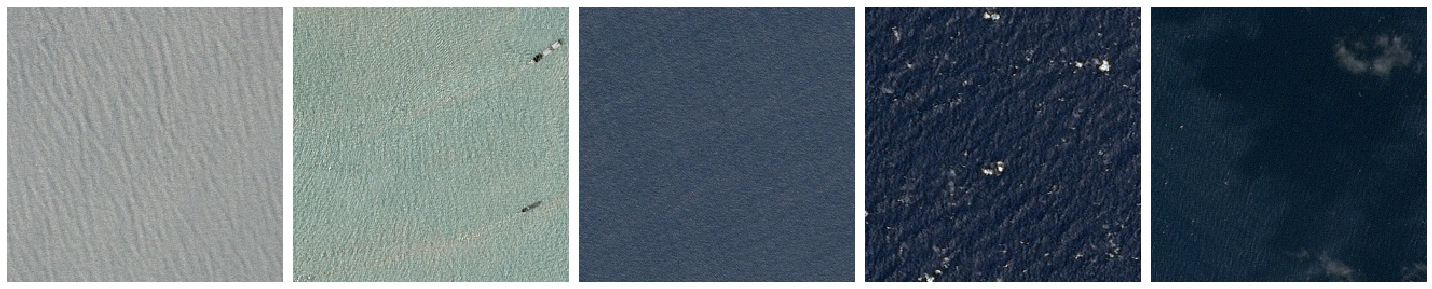

In [105]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:10])

In [12]:
# model 4-layer CNN (see below for details)
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [13]:
# ADAM optimizer
# Cross Entropy for loss
# Record accurarcy

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [15]:
# Save a model checkpoint at each epoch based on validation loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

# Stop early of overfitting (validation loss does not improve for 2+ epochs)
overfit = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3
)

In [16]:
# Train the model and record history
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=[checkpoint, overfit],
    validation_data=valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1046 steps, validate for 448 steps
Epoch 1/100
1045/1046 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.7832WARNING:tensorflow:From /home/b/.conda/envs/airbus/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints/assets
1046/1046 [==============================] - 334s 319ms/step - loss: 0.4701 - accuracy: 0.7832 - val_loss: 0.3985 - val_accuracy: 0.8150
Epoch 2/100
 462/1046 [============>.................] - ETA: 2:08 - loss: 0.3427 - accuracy: 0.8500

KeyboardInterrupt: 

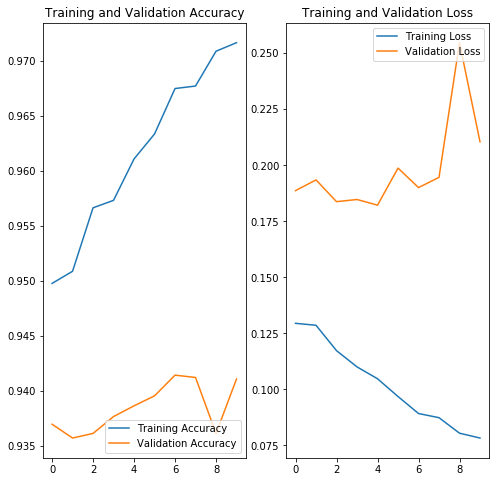

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot history of loss and accurarcy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('binary_classifier_results2.png')

In [33]:
# garbage collect & clear Keras session before U-Net
gc.collect()
K.clear_session()

# 2. U-Net Model
Following [this](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) submission notebook from Kaggle.

Mostly using code from the above notebook, but we rewrote the model in tensorflow2 in order to understand the architechure and simplified some components

In [2]:
class UNetParams():
    def __init__(self):
        self.batch_size = 4
        self.edge_crop = 16
        self.num_epochs= 100
        self.gaussian_noise = 0.1
        self.img_scaling = (1, 1)
        self.max_train_steps = 1000
        
unet_params = UNetParams()

In [3]:
# Helpers for decoding the masks 
# From: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
# Get the masks from kaggle file
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head(5)

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Check Decoding->Encoding RLE_0: 15 -> RLE_1: 5


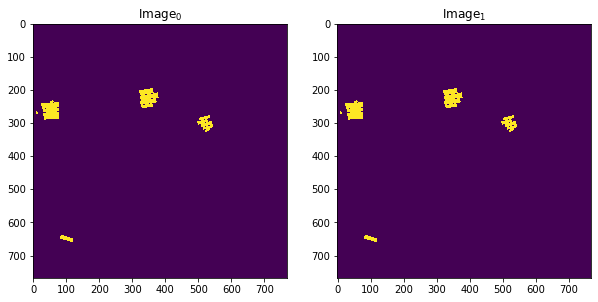

In [5]:
# Plot a mask to test the helper methods
# Image is hard coded to a image with max number of ships (15)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="11f3bae66.jpg"')['EncodedPixels'] # 15 ships in the image
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
96010,7fa9d2cb3.jpg,6,1.0,[1.0],128.498047
50209,42dea589b.jpg,0,0.0,[0.0],84.425781
182048,f2176485a.jpg,1,1.0,[1.0],136.539062
39942,354f27332.jpg,1,1.0,[1.0],95.401367
173240,e66f192d2.jpg,0,0.0,[0.0],128.984375


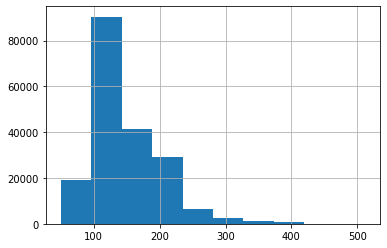

In [6]:
# group images by number of ships
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# Remove images with < 50kb, the could be corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024 if os.path.exists(os.path.join(train_image_dir, c_img_id)) else 0.0)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [7]:
# Split training into training and validation sets

from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


In [8]:
# custom image generator
def make_image_gen(in_df, params = unet_params):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if params.img_scaling is not None:
                c_img = c_img[::params.img_scaling[0], ::params.img_scaling[1]]
                c_mask = c_mask[::params.img_scaling[0], ::params.img_scaling[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=params.batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [9]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 0.7254901960784313
y (4, 768, 768, 1) 0 0


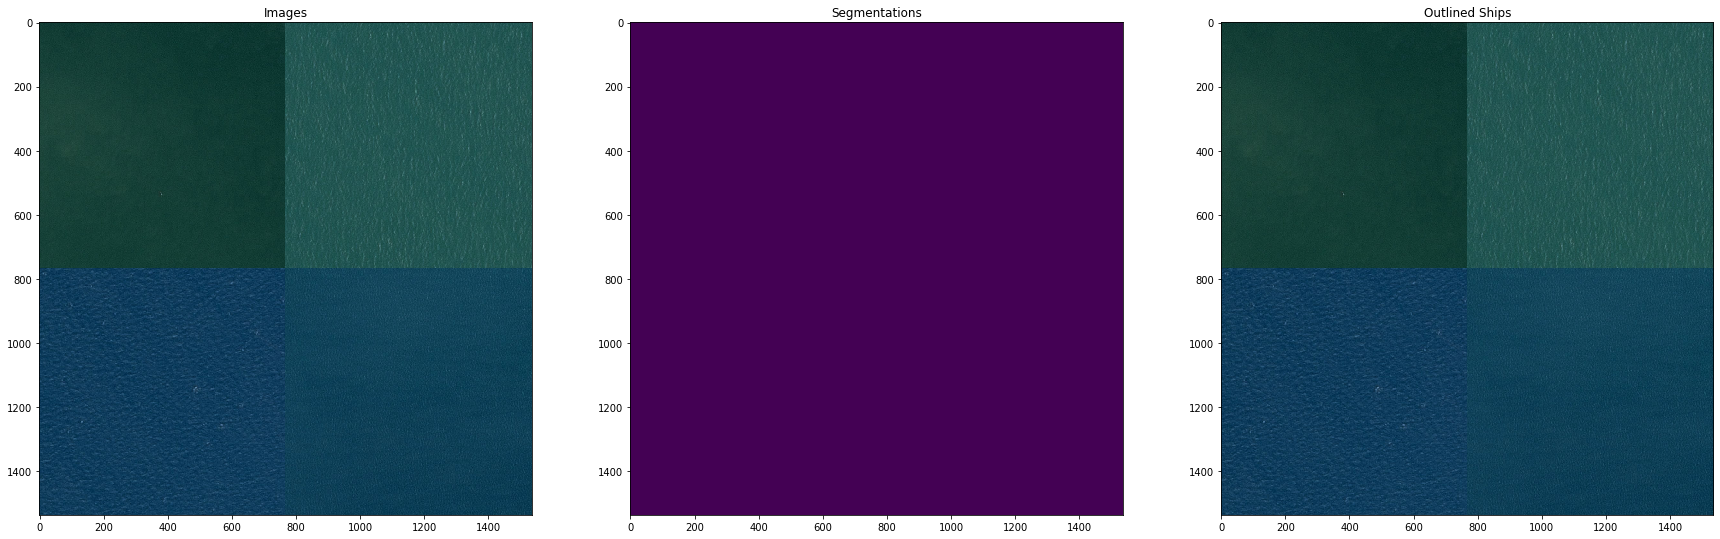

In [10]:
# plot the batching with masks
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('images/overview.png')

In [11]:
valid_x, valid_y = next(make_image_gen(valid_df))
print(valid_x.shape, valid_y.shape)

(4, 768, 768, 3) (4, 768, 768, 1)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center = False, 
    samplewise_center = False,
    rotation_range = 15, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],  
    horizontal_flip = True, 
    vertical_flip = True,
    fill_mode = 'reflect',
    data_format = 'channels_last'
)

# brightness can be problematic since it seems to change the labels differently from the images 

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

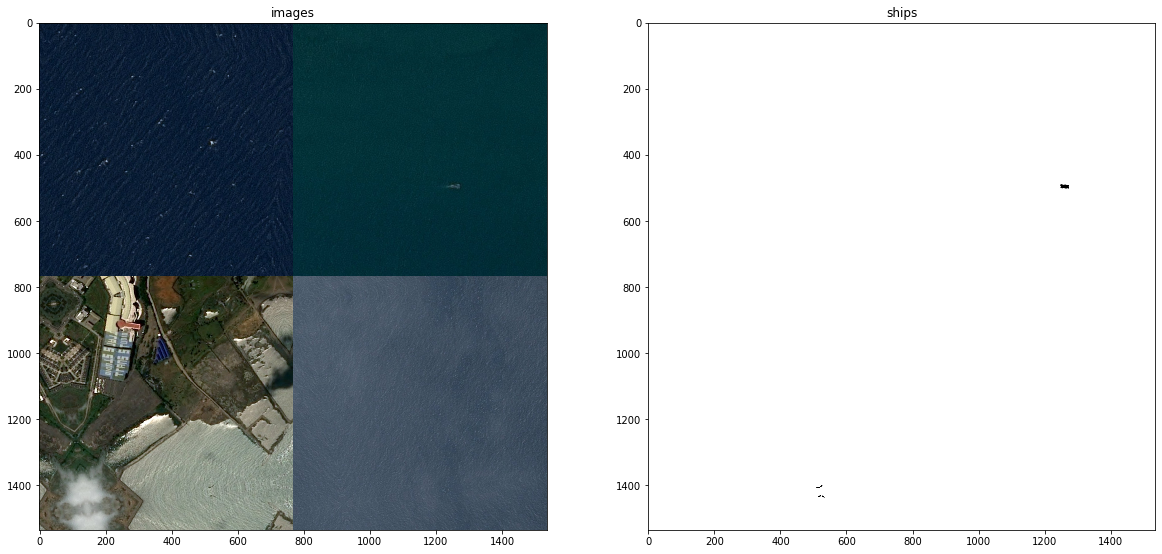

In [13]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [14]:
# garbarge collect before building the model
gc.collect()
K.clear_session()

In [15]:
# Build the U-Net Model

input_img = Input(t_x.shape[1:], name = 'RGB_Input')
input_layer = GaussianNoise(unet_params.gaussian_noise)(input_img)
input_layer = BatchNormalization()(input_layer)

def conv_down(filter_, in_layer, name, kernel=(3, 3), activation='relu', padding='same'):
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv1')(in_layer)
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv2')(l)
    return l
    
def pool(in_layer, name, pool_size=(2, 2)):
    return MaxPooling2D(pool_size, name=name+'_pool')(in_layer)

def conv_up(filter_, in_layer, conv_down_layer, name, upsample_size=(2, 2), kernel=(3, 3), activation='relu', padding='same'):
    l = UpSampling2D(upsample_size, name=name+'_upsample')(in_layer)
    l = concatenate([l, conv_down_layer], name=name+'_concat')
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv1')(l)
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv2')(l)
    return l

d1 = conv_down(8, input_img, name='d1')
dp1 = pool(d1, name='d1')
d2 = conv_down(16, dp1, name='d2')
dp2 = pool(d2, name='d2')
d3 = conv_down(32, dp2, name='d3')
dp3 = pool(d3, name='d3')
d4 = conv_down(64, dp3, name='d4')
dp4 = pool(d4, name='d4')
b = conv_down(128, dp4, name='b')
u1 = conv_up(64, b, d4, name='u1')
u2 = conv_up(32, u1, d3, name='u2')
u3 = conv_up(16, u2, d2, name='u3')
u4 = conv_up(8, u3, d1, name='u4')

out = Conv2D(1, (1, 1), activation='sigmoid', name='out_conv1')(u4)
out = Cropping2D((unet_params.edge_crop, unet_params.edge_crop), name='out_crop')(out)
out = ZeroPadding2D((unet_params.edge_crop, unet_params.edge_crop), name='out_pad')(out)

unet = models.Model(inputs=[input_img], outputs=[out], name="UNet")
unet.summary()

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
d1_conv1 (Conv2D)               (None, 768, 768, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
d1_conv2 (Conv2D)               (None, 768, 768, 8)  584         d1_conv1[0][0]                   
__________________________________________________________________________________________________
d1_pool (MaxPooling2D)          (None, 384, 384, 8)  0           d1_conv2[0][0]                   
_______________________________________________________________________________________________

In [16]:
# Loss and metrics
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

unet.compile(optimizer=Adam(1e-4), loss=binary_crossentropy, metrics=[dice_coef])

In [17]:
# model callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(
    weight_path, 
    monitor='val_dice_coef', 
    verbose=1, 
    save_best_only=True, 
    mode='max', 
    save_weights_only = True
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_dice_coef', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='max', 
    epsilon=0.0001, 
    cooldown=2, 
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_dice_coef", 
    mode="max", 
    patience=15
)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [18]:
# train the model
step_count = min(unet_params.max_train_steps, train_df.shape[0]//unet_params.batch_size)
aug_gen = create_aug_gen(make_image_gen(train_df))

loss_history = [
    unet.fit(
        aug_gen, 
        steps_per_epoch=step_count, 
        epochs=unet_params.num_epochs, 
        validation_data=(valid_x, valid_y),
        callbacks=callbacks_list
    )
]

  ...
    to  
  ['...']
Train for 1000 steps, validate on 4 samples
Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.0419 - dice_coef: 0.7457
Epoch 00001: val_dice_coef improved from -inf to 0.75087, saving model to seg_model_weights.best.hdf5
1000/1000 [==============================] - 452s 452ms/step - loss: 0.0419 - dice_coef: 0.7457 - val_loss: 0.0019 - val_dice_coef: 0.7509
Epoch 2/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.0175 - dice_coef: 0.7843
Epoch 00002: val_dice_coef did not improve from 0.75087
1000/1000 [==============================] - 447s 447ms/step - loss: 0.0175 - dice_coef: 0.7845 - val_loss: 0.0019 - val_dice_coef: 0.7509
Epoch 3/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.0176 - dice_coef: 0.7920
Epoch 00003: val_dice_coef did not improve from 0.75087
1000/1000 [==============================] - 448s 448ms/step - loss: 0.0176 - dice_coef: 0.7917 - val_loss: 0.0019 - val_dice_coef: 0.7509


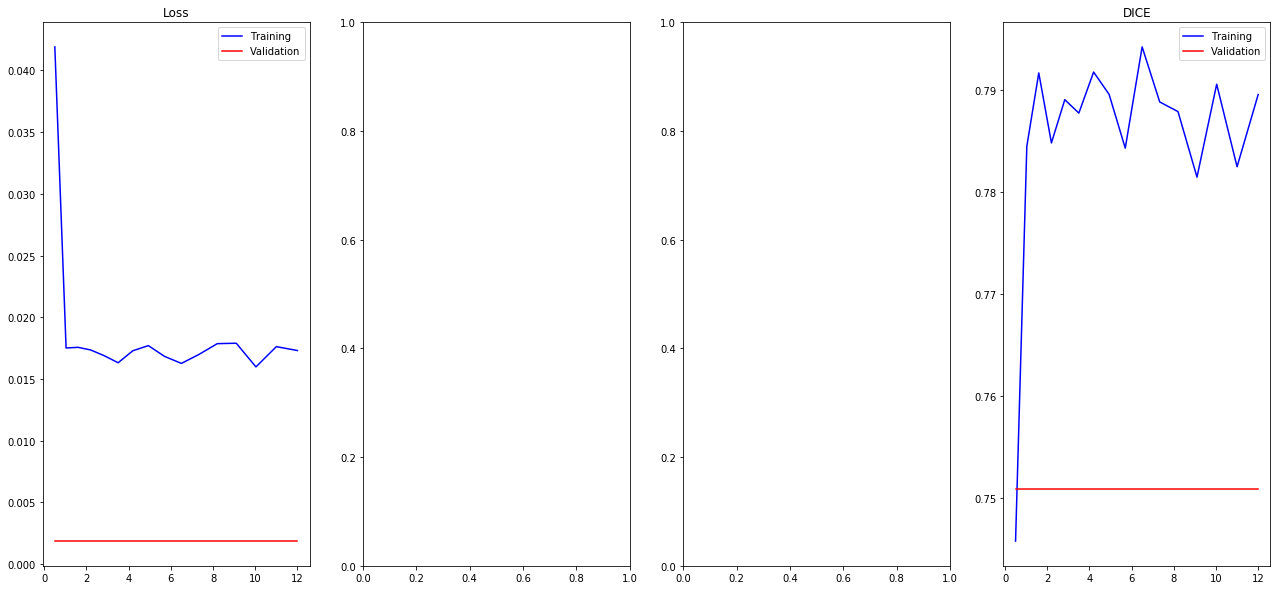

In [21]:
# Plot loss history
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

#     _ = ax2.plot(epich, np.concatenate(
#         [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
#                      epich, np.concatenate(
#             [mh.history['val_true_positive_rate'] for mh in loss_history]),
#                      'r-')
#     ax2.legend(['Training', 'Validation'])
#     ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
#     _ = ax3.plot(epich, np.concatenate(
#         [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
#                      epich, np.concatenate(
#             [mh.history['val_binary_accuracy'] for mh in loss_history]),
#                      'r-')
#     ax3.legend(['Training', 'Validation'])
#     ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [30]:
# save model
unet.load_weights(weight_path)
unet.save('seg_model_03_05_midnight.h5')

if unet_params.img_scaling is not None:
    fullres_model = models.Sequential()
    fullres_model.add(AvgPool2D(unet_params.img_scaling, input_shape = (None, None, 3)))
    fullres_model.add(unet)
    fullres_model.add(UpSampling2D(unet_params.img_scaling))
else:
    fullres_model = unet
fullres_model.save('fullres_model_03_05_midnight.h5')

9cf1d0f69.jpg
9cf1d0f69.jpg ../data/test_v2/9cf1d0f69.jpg
0b13774e2.jpg
0b13774e2.jpg ../data/test_v2/0b13774e2.jpg
a6a3cf794.jpg
a6a3cf794.jpg ../data/test_v2/a6a3cf794.jpg
fa0e8456d.jpg
fa0e8456d.jpg ../data/test_v2/fa0e8456d.jpg
2640fdade.jpg
2640fdade.jpg ../data/test_v2/2640fdade.jpg
75845662a.jpg
75845662a.jpg ../data/test_v2/75845662a.jpg
9936c45c5.jpg
9936c45c5.jpg ../data/test_v2/9936c45c5.jpg
b20c0ea27.jpg
b20c0ea27.jpg ../data/test_v2/b20c0ea27.jpg
4f98f9cc8.jpg
4f98f9cc8.jpg ../data/test_v2/4f98f9cc8.jpg
78985cc65.jpg
78985cc65.jpg ../data/test_v2/78985cc65.jpg
9e3ab24ef.jpg
9e3ab24ef.jpg ../data/test_v2/9e3ab24ef.jpg
1b06d60b4.jpg
1b06d60b4.jpg ../data/test_v2/1b06d60b4.jpg
5cdaddfeb.jpg
5cdaddfeb.jpg ../data/test_v2/5cdaddfeb.jpg
505b91c70.jpg
505b91c70.jpg ../data/test_v2/505b91c70.jpg
831fce82e.jpg
831fce82e.jpg ../data/test_v2/831fce82e.jpg
87c035e3f.jpg
87c035e3f.jpg ../data/test_v2/87c035e3f.jpg
192448afd.jpg
192448afd.jpg ../data/test_v2/192448afd.jpg
aece7fe33.jpg


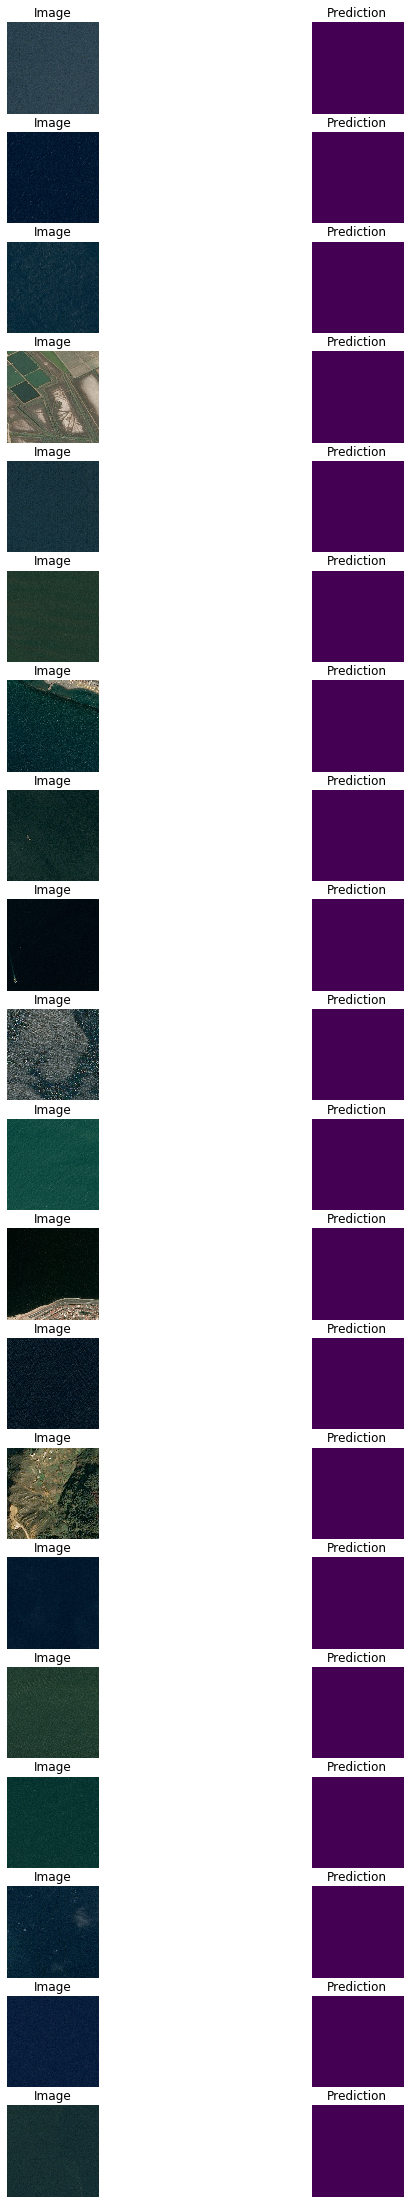

In [39]:
# Predict
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, os.listdir(test_image_dir)):
    print(c_img_name)
    if '.jpg' in c_img_name:
        c_path = os.path.join(test_image_dir, c_img_name)
        print(c_img_name, c_path)
        c_img = imread(c_path)
        first_img = np.expand_dims(c_img, 0)/255.0
        first_seg = fullres_model.predict(first_img)
        ax1.imshow(first_img[0])
        ax1.set_title('Image')
        ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
        ax2.set_title('Prediction')
fig.savefig('test_predictions_03_05_midnight_02.png')